A sentiment analysis app is designed to evaluate the emotional tone of a user's message. When a user inputs a message into the app, it processes the text and classifies the sentiment as positive, negative, or neutral. This is done using natural language processing (NLP) and deep learning techniques that understand the context and emotions expressed in the text. Such apps are widely used in social media monitoring, customer feedback analysis, and product review summarization to better understand public opinion.

In deep learning, RNN (Recurrent Neural Network), LSTM (Long Short-Term Memory), and GRU (Gated Recurrent Unit) are specialized architectures for handling sequential data, especially text. RNNs allow previous inputs in a sequence to influence the current output, making them suitable for language tasks. However, they struggle with long-term dependencies due to vanishing gradient problems. LSTM networks improve upon RNNs by introducing memory cells and gating mechanisms that control which information is remembered or forgotten over time. GRUs simplify LSTMs by combining certain gates, offering similar performance with fewer parameters and faster training.

These models are crucial in building a sentiment analysis app because they can understand the sequence and structure of words in a sentence. RNNs capture context by remembering previous words, while LSTMs and GRUs are better at handling long and complex sentences without losing important emotional cues. By training on large datasets of labeled text, these networks learn to associate patterns in language with specific sentiments, making them highly effective for accurately classifying user input in sentiment analysis tasks.

In [1]:
import numpy as np # for data shaping and manipulation
import pandas as pd # for dataframe creation and manipulation
import matplotlib.pyplot as plt # for data visualization

from sklearn.model_selection import train_test_split # to split data into training and testing sets
from sklearn.metrics import confusion_matrix, classification_report # to get a confusion matrix and classification report of model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, Bidirectional, LSTM, Dense, Dropout, LayerNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import bz2 # to work with bz2 ie compressed data files
import csv # to work with csv files
import re # to work with regular expressions

In [2]:
with bz2.BZ2File('data.ft.txt.bz2') as f:
    training_data = [f.readline().decode('utf-8').strip() for _ in range(3000)] # first 3000 lines will work as training data
    testing_data = [f.readline().decode('utf-8').strip() for _ in range(1000)] # next 1000 lines will work as test data

# check the size of the training and test data to ensure they were split correctly
print("Training data subset size:", len(training_data))
print("Test data subset size:", len(testing_data))

Training data subset size: 3000
Test data subset size: 1000


In [3]:
# checking first lines of testing and training data
print(training_data[0])
print(testing_data[0])

__label__2 Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I'm in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life's hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"
__label__2 Profound, Poetic, and Disturbing: A terrific read. Very dry, engaging, and clips along at a good pace. I finished it in less than three hours, and felt that I had witnessed part of myself on Camus' stage. M. Meursault is, for the most part, an ordinary person who has been benumbed by a daily existence of "getting by." Finding himself so dulled, that finally, he is a mere spectator in his own life. "Effect" instead of "Cause." The story begi

In [3]:


# now we need to separate the labels from the text ie separate 1 and/or 2 from '__label__1' and/or '__label__2' respectively
# we will need these numbers separate to train the model using them and they are to be removed from the labels otherwise
# the model will already know the answer from the label number so it will be useless as it is not predicting a value

training_labels = [int(re.findall(r'__label__(\d)', line)[0]) for line in training_data] # create a list of label numbers from the training data
training_texts = [re.sub(r'__label__\d ', '', line) for line in training_data] # remove the label numbers from the training data

# do the same thing with testing data
testing_labels = [int(re.findall(r'__label__(\d)', line)[0]) for line in testing_data]
testing_texts = [re.sub(r'__label__\d ', '', line) for line in testing_data]

# convert tesing and training labels to binary (if label is 1, convert to 0, else convert to 1)
training_labels = [0 if label == 1 else 1 for label in training_labels]
testing_labels = [0 if label == 1 else 1 for label in testing_labels]

In [5]:
# checking first 10 elements of training and testing labels to see if they were successfully created and converted
print(training_labels[:10])
print(testing_labels[:10])

[1, 1, 0, 1, 1, 0, 0, 0, 1, 0]
[1, 1, 1, 1, 0, 1, 1, 1, 1, 0]


In [4]:
# now we have to clean the text by removing stop words and converting words to their root form to simplify learing process of the model

# import nltk, in built stopwords and stemmer that converts words to their root format
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# create a function to clean the text by removing stop words and converting words to their root form
def clean_text(text):
    ps = PorterStemmer() # create an object of PorterStemmer
    
    stop_words = set(stopwords.words('english')) # create a set of in-built stopwords
    
    text = text.lower() # convert text to lowercase
    
    text = re.sub(r'[^a-z\s]', '', text) # remove non-alphabetic characters from the text using regular expressions but keep spaces

    words = text.split() # create a list of each word where each word is separated by a space
    
    words = [ps.stem(word) for word in words if word not in stop_words] # apply porter stemmer on each word in the list so that stopwords are removed
    
    return " ".join(words) # join the words back into a string and return it

# apply this function to the training and testing texts to clean them
training_texts = [clean_text(text) for text in training_texts]
testing_texts = [clean_text(text) for text in testing_texts]

In [7]:
# checking if the text was cleared by checking first line of both training and testing text
print(training_texts[0])
print(testing_texts[0])

great cd love pat one great voic gener listen cd year still love im good mood make feel better bad mood evapor like sugar rain cd ooz life vocal jusat stuun lyric kill one life hidden gem desert isl cd book never made big beyond everytim play matter black white young old male femal everybodi say one thing sing
profound poetic disturb terrif read dri engag clip along good pace finish less three hour felt wit part camu stage meursault part ordinari person benumb daili exist get find dull final mere spectat life effect instead caus stori begin death end death fold found new life whether maman fiance meursault rebirth conscious final minut perhap stori find someth meursault heed warn seem glare milehigh neon caus effect get live live heroic instead spectat simpli get byquot


In [5]:
# now we have to preprocess text data by limiting it to some constraints so that model can be trained easily
# and we also have to convert text data into numeric data as machine learning model only understand numeric data
# we will also create a limit for length of data and truncate and pad long and short data respectively to uniform length

max_words = 1000 # tokenizer will only consider 1000 most common words from the dataset
max_sequence_length = 100 # any text longer than 100 will be truncated and shorter will be padded

tokenizer = Tokenizer(num_words = max_words) # initialize Tokenizer object with 1000 most common words
tokenizer.fit_on_texts(training_texts) # replace each word in 'training_texts' with it's index value

# create training and testing data by using tokenizer and convert text data into numeric data created in previous step 
X_train = tokenizer.texts_to_sequences(training_texts)
X_test = tokenizer.texts_to_sequences(testing_texts)

# pad and truncate data to uniform length
X_train = pad_sequences(X_train, maxlen = max_sequence_length)
X_test = pad_sequences(X_test, maxlen = max_sequence_length)

In [7]:
# create an array of training and testing data

X_train = np.array(X_train)
print(X_train.shape)
X_test = np.array(X_test)
print(X_test.shape)
y_train = np.array(training_labels)
print(y_train.shape)
y_test = np.array(testing_labels)
print(y_test.shape)

(3000, 100)
(1000, 100)
(3000,)
(1000,)


In [8]:
# now we can train an RNN model

# create a bidirectional RNN sequential model
model = Sequential([
    Embedding(input_dim = max_words, output_dim=300, input_length = max_sequence_length),
    Bidirectional(SimpleRNN(128, return_sequences=True, dropout=0.3)),
    LayerNormalization(),
    Bidirectional(SimpleRNN(128, dropout = 0.3)),
    LayerNormalization(),
    Dropout(0.3),
    Dense(64, activation = "relu"),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 5e-5), metrics = ['accuracy'])
# compile the model with Adam optimizer, binary crossentropy loss function and evaluate accuracy at each step

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# train the model with input going 50 times through the model and batch size of 512 ie weights change after every 512 samples
# verbose = 1 means with each epoch we get to see progress bar with updated values of accuracy and loss
history = model.fit(X_train, y_train, epochs = 50, batch_size = 512, validation_data = (X_test, y_test), callbacks = [early_stopping], verbose = 1)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 820ms/step - accuracy: 0.5008 - loss: 0.9057 - val_accuracy: 0.4720 - val_loss: 0.7881
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 748ms/step - accuracy: 0.4990 - loss: 0.8806 - val_accuracy: 0.4770 - val_loss: 0.7739
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 710ms/step - accuracy: 0.5059 - loss: 0.8454 - val_accuracy: 0.4840 - val_loss: 0.7447
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 712ms/step - accuracy: 0.5043 - loss: 0.8339 - val_accuracy: 0.4880 - val_loss: 0.7321
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 722ms/step - accuracy: 0.5025 - loss: 0.8014 - val_accuracy: 0.4930 - val_loss: 0.7204
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 708ms/step - accuracy: 0.5160 - loss: 0.7652 - val_accuracy: 0.4960 - val_loss: 0.7118
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 716ms/step - accuracy: 0.4839 - loss: 0.7673 - val_accuracy: 0.4930 - val_loss: 0.7059
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 734ms/step - accuracy: 0.5085 - loss: 0.7567 - val_accuracy: 0.5020 - val_loss:

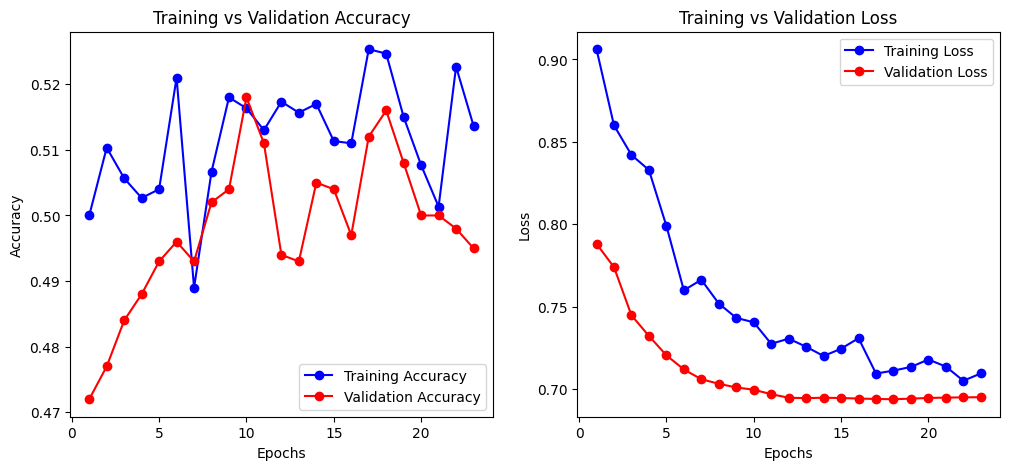

In [9]:
# now we will graphically analyze the change in accuracy and loss in the model as the input goes through the model

epochs = range(1, len(history.history['accuracy']) + 1) # get an array of epoch numbers [1,2,3,...50] as there are 50 epochs in our model
train_acc = history.history['accuracy'] # get an array of training accuracy for each epoch
val_acc = history.history['val_accuracy'] # get an array of validation accuracy for each epoch
train_loss = history.history['loss'] # get an array of training loss for each epoch
val_loss = history.history['val_loss'] # get an array of validation loss for each epoch

plt.figure(figsize=(12, 5))

# subplot for epoch vs training accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# subplot for epoch vs validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [10]:
# let's also analyze the model's performance using confusion matrix and classification report

y_pred = model.predict(X_test) # predict ourput for test data
y_pred = (y_pred > 0.5) # if output is greater than 0.5 then convert it to 1, else convert it to 0
cm = confusion_matrix(y_test, y_pred) # create confusion matrix of predicted and actual output
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred) # also print the classification report of predicted and actual output
print("Classification Report:")
print(report)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Confusion Matrix:
[[103 411]
 [ 73 413]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.20      0.30       514
           1       0.50      0.85      0.63       486

    accuracy                           0.52      1000
   macro avg       0.54      0.53      0.46      1000
weighted avg       0.54      0.52      0.46      1000



In [11]:
# now let's recreate the model but using LSTM also to make the model more accurate

model = Sequential([
    Embedding(input_dim = max_words, output_dim=300, input_length = max_sequence_length),
    Bidirectional(LSTM(128, return_sequences = True, recurrent_dropout = 0.2)), # bidirectional LSTM layer has 128 neurons in each direction
    # and next layer will require entire sequence of output not just the last output and 20% neurons will be de-activated randomly to avoid overfitting
    LayerNormalization(), # normalize the output of previous layer
    Dropout(0.3), # de-activate 30% neurons randomly again before output of previous layer goes to next layer
    Bidirectional(LSTM(128, recurrent_dropout = 0.2)), # another bidirectional LSTM layer with 128 neurons in each direction
    # does not keep record of entire sequence of output but only the last output and 20% neurons will be de-activated
    # because after it, the output will be passed to dense layer
    LayerNormalization(), # normalize the output of previous layer
    Dropout(0.3), # de-activate 30% neurons randomly again before output of previous layer goes to next layer 
    Dense(64, activation = "relu"), # apply relu activation function to the output of previous layer to change weights and biases before input goes for next epoch
    Dropout(0.2), # de-activate 20% neurons randomly again before output of previous layer goes to next layer
    Dense(1, activation = 'sigmoid') # apply sigmoid activation function to the output of previous layer to change weights and biases before input goes for next epoch
])

model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate=5e-5), metrics = ['accuracy'])
# compile the model with Adam optimizer and binary cross entropy loss function, learning rate of 0.00005 and
# show accuracy and validation loss of model at each epoch

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
# monitor validation loss and if it does not decrease for 5 epochs, stop training and restore best weights found till now

# train the model just as before
history = model.fit(X_train, y_train, epochs = 50, batch_size = 512, validation_data = (X_test, y_test), callbacks = [early_stopping], verbose = 1)

Epoch 1/50


c:\Users\nishc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5164 - loss: 0.8393 - val_accuracy: 0.5360 - val_loss: 0.6953
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5070 - loss: 0.7953 - val_accuracy: 0.5600 - val_loss: 0.6801
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5179 - loss: 0.7393 - val_accuracy: 0.5690 - val_loss: 0.6720
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.5441 - loss: 0.7111 - val_accuracy: 0.5900 - val_loss: 0.6664
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.5601 - loss: 0.7022 - val_accuracy: 0.6140 - val_loss: 0.6604
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.5679 - loss: 0.6970 - val_accuracy: 0.6310 - val_loss: 0.6524
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5821 - loss: 0.6721 - val_accuracy: 0.6430 - val_loss: 0.6441
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5973 - loss: 0.6642 - val_accuracy: 0.6500 - val_loss: 0.6366
Epoch 9/50
6/6 ━━━━

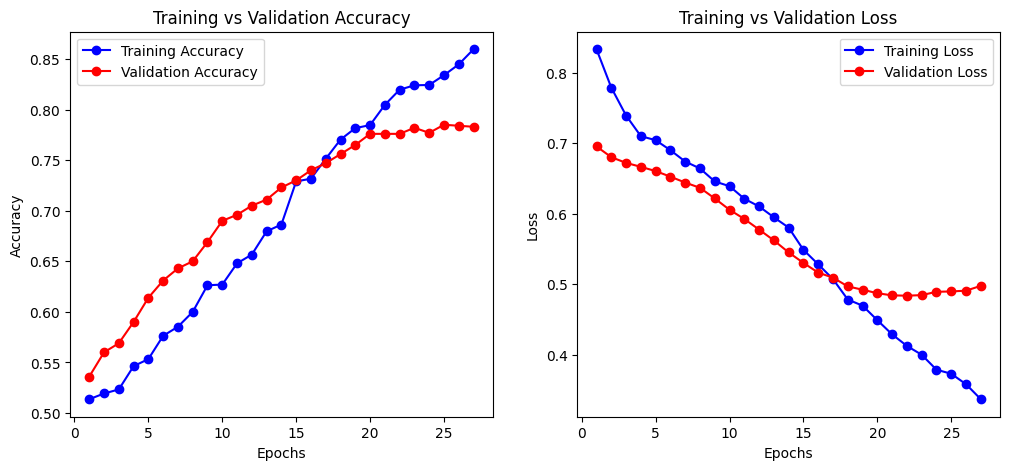

In [12]:
# now we will graphically analyze the change in accuracy and loss in the model as the input goes through the model

epochs = range(1, len(history.history['accuracy']) + 1) # get an array of epoch numbers [1,2,3,...50] as there are 50 epochs in our model
train_acc = history.history['accuracy'] # get an array of training accuracy for each epoch
val_acc = history.history['val_accuracy'] # get an array of validation accuracy for each epoch
train_loss = history.history['loss'] # get an array of training loss for each epoch
val_loss = history.history['val_loss'] # get an array of validation loss for each epoch

plt.figure(figsize=(12, 5))

# subplot for epoch vs training accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# subplot for epoch vs validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [13]:
# let's also analyze the model's performance using confusion matrix and classification report

y_pred = model.predict(X_test) # predict ourput for test data
y_pred = (y_pred > 0.5) # if output is greater than 0.5 then convert it to 1, else convert it to 0
cm = confusion_matrix(y_test, y_pred) # create confusion matrix of predicted and actual output
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred) # also print the classification report of predicted and actual output
print("Classification Report:")
print(report)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step
Confusion Matrix:
[[409 105]
 [119 367]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.79       514
           1       0.78      0.76      0.77       486

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000



In [2]:
# now we will recreate and train the model but with GRU to optimize it further
# everything is same except LSTM becomes GRU
# recurrent dropout means that we are dropping some of the connections in the recurrent layer

model = Sequential([
    Embedding(input_dim = max_words, output_dim = 300, input_length = max_sequence_length),
    Bidirectional(GRU(128, return_sequences = True, dropout = 0.3, recurrent_dropout = 0.2)),
    LayerNormalization(),
    Bidirectional(GRU(128, dropout = 0.3, recurrent_dropout = 0.2)),
    LayerNormalization(),
    Dropout(0.3),
    Dense(64, activation = "relu"),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate=5e-5), metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

history = model.fit(X_train, y_train, epochs = 50, batch_size = 512, validation_data = (X_test, y_test), callbacks = [early_stopping], verbose = 1)

NameError: name 'Sequential' is not defined

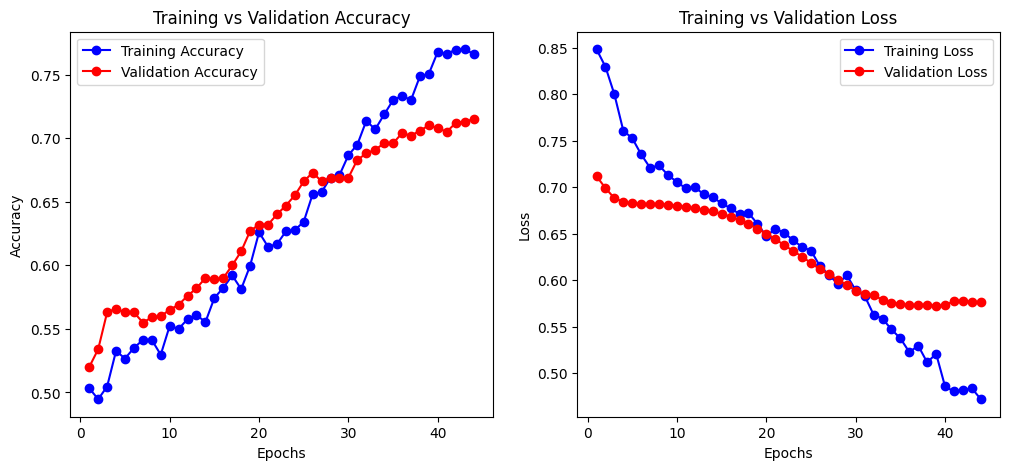

In [15]:
# now we will graphically analyze the change in accuracy and loss in the model as the input goes through the model

epochs = range(1, len(history.history['accuracy']) + 1) # get an array of epoch numbers [1,2,3,...50] as there are 50 epochs in our model
train_acc = history.history['accuracy'] # get an array of training accuracy for each epoch
val_acc = history.history['val_accuracy'] # get an array of validation accuracy for each epoch
train_loss = history.history['loss'] # get an array of training loss for each epoch
val_loss = history.history['val_loss'] # get an array of validation loss for each epoch

plt.figure(figsize=(12, 5))

# subplot for epoch vs training accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# subplot for epoch vs validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [16]:
# let's also analyze the model's performance using confusion matrix and classification report

y_pred = model.predict(X_test) # predict ourput for test data
y_pred = (y_pred > 0.5) # if output is greater than 0.5 then convert it to 1, else convert it to 0
cm = confusion_matrix(y_test, y_pred) # create confusion matrix of predicted and actual output
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred) # also print the classification report of predicted and actual output
print("Classification Report:")
print(report)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step
Confusion Matrix:
[[351 163]
 [127 359]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.68      0.71       514
           1       0.69      0.74      0.71       486

    accuracy                           0.71      1000
   macro avg       0.71      0.71      0.71      1000
weighted avg       0.71      0.71      0.71      1000



In [ ]:
# now we will create a function that will predict the sentiment of the text

import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_sentiment(text, model, tokenizer, max_sequence_length=100):
    # clean text
    text = clean_text(text)
    
    # convert text to sequence
    sequence = tokenizer.texts_to_sequences([text])
    
    # pad sequence by truncating or padding to match the max_sequence_length
    padded_sequence = pad_sequences(sequence, maxlen = max_sequence_length)
    
    # model returns single value in 2D array like [[0.98]], return it as a single value
    prediction = model.predict(padded_sequence)[0][0]
    
    # determine sentiment based on prediction value
    sentiment = "Positive" if prediction > 0.4 else "Negative"
    
    return sentiment # return sentiment and confidence score

# testing the function on some test sentences

test_sentences = [
    "I love this product! It's amazing.",
    "This is the worst service I have ever experienced.",
]

for sentence in test_sentences:
    sentiment, confidence = predict_sentiment(sentence, model, tokenizer)
    print(f"Text: {sentence}\nPredicted Sentiment: {sentiment} (Confidence: {confidence:.4f})\n")

In [22]:
# save the model and tokenizer using pickle module

model.save("lstm_model.h5")

import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)